### Train classifier on 2023 ROIs

In [1]:
import os
import numpy as np
import rasterio
from rasterio import features
from spectral.io import envi
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
from scipy.ndimage import generic_filter
from scipy import stats
from rasterio.plot import reshape_as_image

# -------------------------------
# 1. Load stacked image
# -------------------------------
img_path = "stacked/2023"
with rasterio.open(img_path) as src:
    img = src.read()
    profile = src.profile
    rgb = reshape_as_image(img)[:, :, :3]  # for display
    transform = src.transform

plt.figure(figsize=(8, 6))
plt.imshow((rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb)))
plt.title("Original stacked image (RGB)")
plt.axis("off")
plt.show()

# -------------------------------
# 2. Load all ROI shapefiles
# -------------------------------
roi_dir = "ROIs/2023_x4_v2_SHPs"
classes = ["Cloud", "Jungle", "Mining", "Water"]

X_list, y_list = [], []

for class_id, class_name in enumerate(classes):
    shp_path = os.path.join(roi_dir, f"{class_name}.shp")
    roi_gdf = gpd.read_file(shp_path)

    # Combine all polygons in this shapefile into one mask
    mask = features.geometry_mask(
        roi_gdf.geometry,
        out_shape=(img.shape[1], img.shape[2]),
        transform=transform,
        invert=True
    )

    # Extract pixels inside ROI polygons
    ys, xs = np.where(mask)
    pixels = img[:, ys, xs].T

    X_list.append(pixels)
    y_list.append(np.full(len(pixels), class_id))

    print(f"Loaded {len(roi_gdf)} polygons for class '{class_name}' ({len(pixels)} pixels)")

# -------------------------------
# 3a. Stack into proper arrays
# -------------------------------
X_train = np.vstack(X_list)  # shape = (total_pixels, num_bands)
y_train = np.concatenate(y_list)  # shape = (total_pixels,)

print(f"\n✅ X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# -------------------------------
# 3b. Train classifier
# -------------------------------
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)
clf.fit(X_train, y_train)



RasterioIOError: stacked/2023: No such file or directory

### Classify each image 2013-2023

In [91]:
def class_img(img_name):
    img_path = "Stacked/" + img_name
    with rasterio.open(img_path) as src:
        img = src.read()
        profile = src.profile
        rgb = reshape_as_image(img)[:, :, :3]  # for display
        transform = src.transform
    
    # -------------------------------
    # 4. Classify entire image
    # -------------------------------
    h, w = img.shape[1], img.shape[2]
    X = img.reshape(img.shape[0], -1).T
    y_pred = clf.predict(X)
    classified = y_pred.reshape(h, w)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(classified, cmap="tab20")
    plt.title("Raw classification")
    plt.axis("off")
    plt.show()
    
    # -------------------------------
    # 5. Smooth result (majority filter)
    # -------------------------------
    def majority_filter(arr, size=3):
        def mode_func(x):
            return stats.mode(x, keepdims=False)[0]
        return generic_filter(arr, mode_func, size=size)
    
    smoothed = majority_filter(classified, size=3)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(smoothed, cmap="tab20")
    plt.title("Smoothed classification")
    plt.axis("off")
    plt.show()
    
    # -------------------------------
    # 6. (Optional) Save smoothed result
    # -------------------------------
    out_path = "classified_" + img_name + "_smooth.tif"
    with rasterio.open(out_path, "w", **profile) as dst:
        dst.write(smoothed.astype(np.uint8), 1)

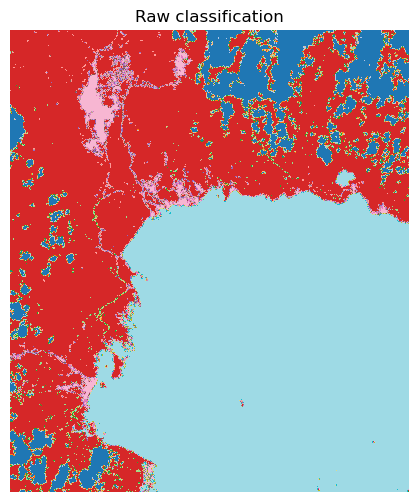

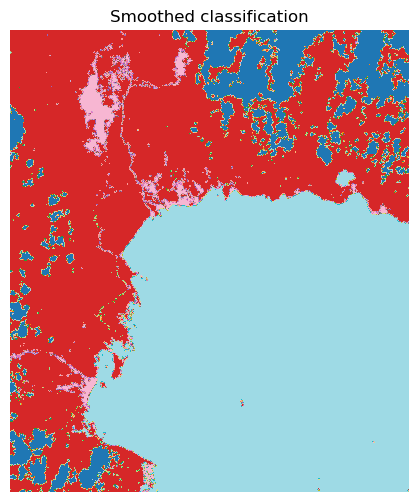

In [93]:
class_img("2013")

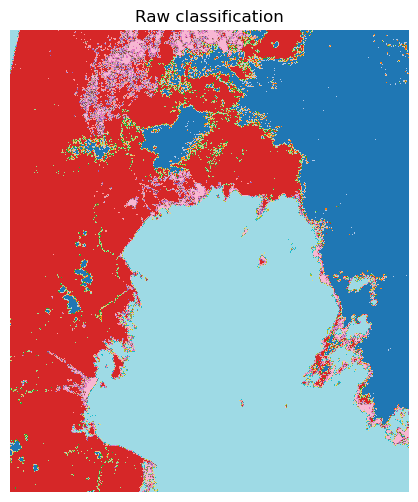

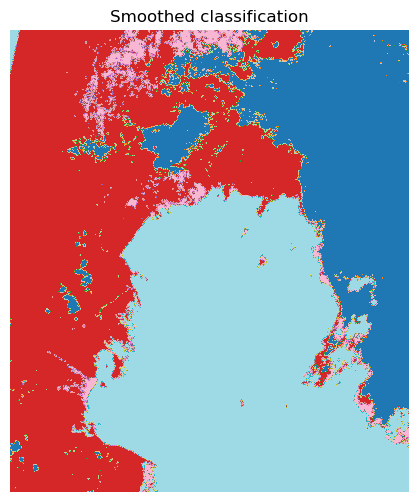

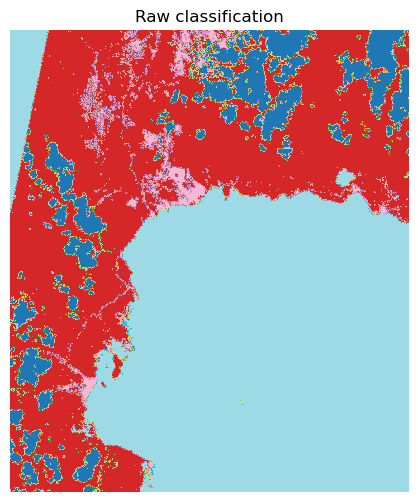

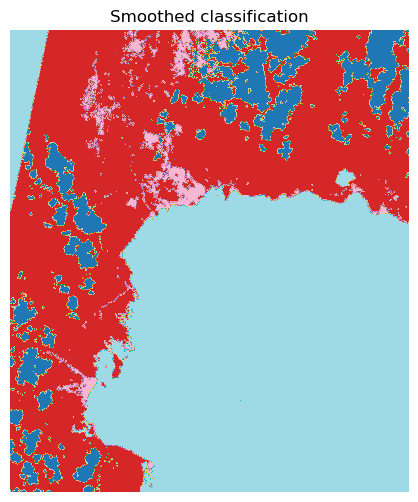

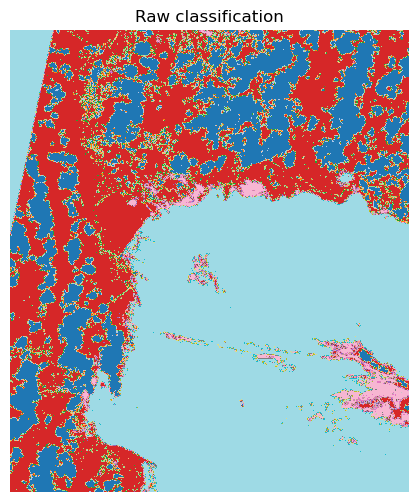

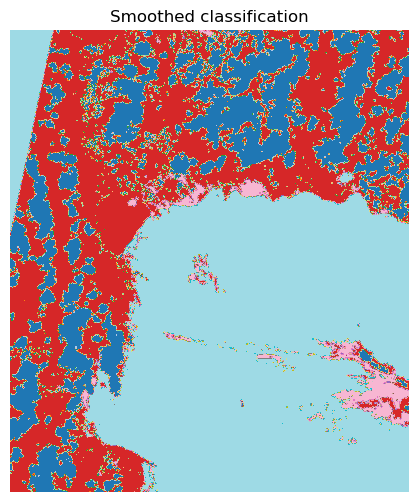

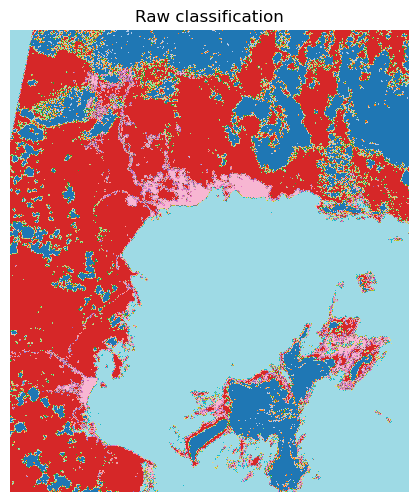

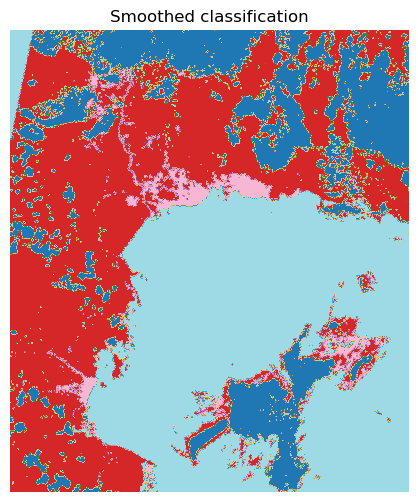

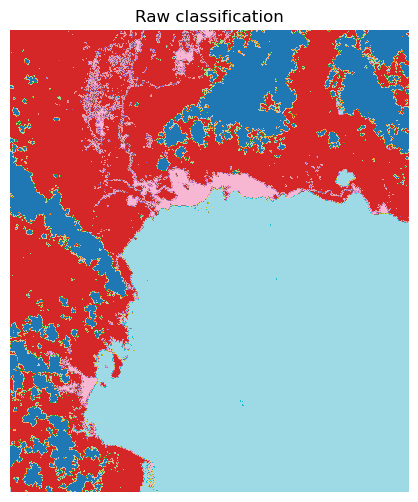

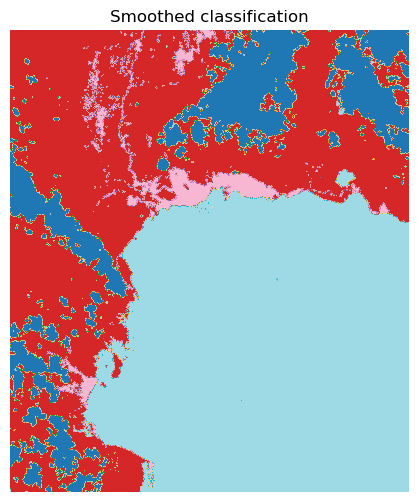

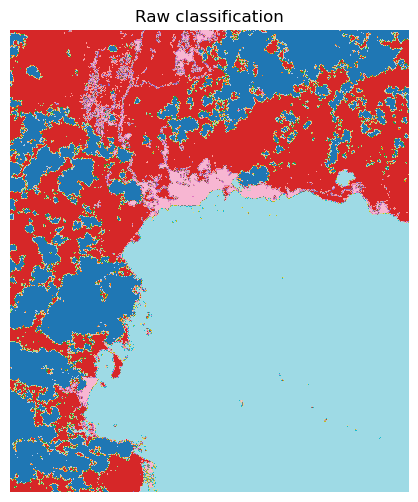

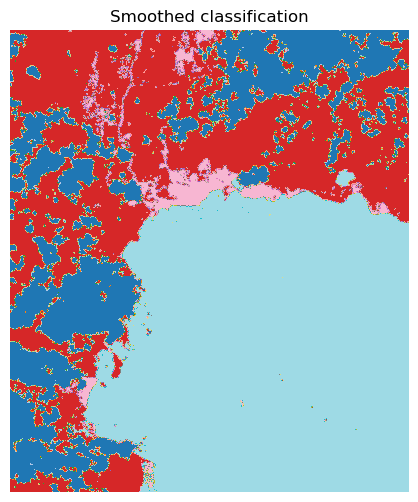

In [95]:
class_img("2016")
class_img("2017")
class_img("2019")
class_img("2020")
class_img("2021")
class_img("2022")
class_img("2023")

### Calculate initial and final states, and year of transition

In [127]:
import glob

# ---------------------------------
# 1. Input setup
# ---------------------------------
data_dir = ""
files = sorted(glob.glob(os.path.join(data_dir, "classified_*_smooth.tif")))
years = [int(os.path.basename(f).split("_")[1]) for f in files]
print("Found years:", years)

# ---------------------------------
# 2. Read and stack rasters
# ---------------------------------
stack = []
meta = None
for f in files:
    with rasterio.open(f) as src:
        data = src.read(1)
        stack.append(data)
        if meta is None:
            meta = src.meta

stack = np.stack(stack, axis=0)  # (time, H, W)
H, W = stack.shape[1:]
print("Stack shape:", stack.shape)

# ---------------------------------
# 3. Compute initial, final, and change years
# ---------------------------------
initial_state = np.full((H, W), -1, dtype=np.int16)
final_state = np.full((H, W), -1, dtype=np.int16)
change_year = np.full((H, W), -1, dtype=np.int16)

for y in range(H):
    pix_seq = stack[:, y, :]
    ocean_mask = np.any(pix_seq == 3, axis=0)
    for x in range(W):
        if ocean_mask[x]:
            continue

        seq = pix_seq[:, x]
        noncloud_idx = np.where(seq != 0)[0]
        if len(noncloud_idx) == 0:
            continue

        first_i = noncloud_idx[0]
        last_i = noncloud_idx[-1]
        initial = seq[first_i]
        final = seq[last_i]

        initial_state[y, x] = initial
        final_state[y, x] = final

        if initial != 1:  # only track jungle origins
            continue

        jungle_to_mine = np.where((seq[:-1] == 1) & (seq[1:] == 2))[0]
        if len(jungle_to_mine) == 0:
            continue

        change_i = jungle_to_mine[0] + 1
        reverted = np.any(seq[change_i:] == 1)
        if not reverted:
            change_year[y, x] = years[change_i]

# ---------------------------------
# 4. Save 3-band output
# ---------------------------------
out_meta = meta.copy()
out_meta.update(dtype=rasterio.int16, count=3)

out_path = os.path.join(data_dir, "jungle_to_mine_change.tif")
with rasterio.open(out_path, "w", **out_meta) as dst:
    dst.write(initial_state, 1)
    dst.write(final_state, 2)
    dst.write(change_year, 3)

print("✅ Saved:", out_path)


Found years: [2013, 2016, 2017, 2019, 2020, 2021, 2022, 2023]
Stack shape: (8, 1290, 1113)
✅ Saved: jungle_to_mine_change.tif


### Plot changes

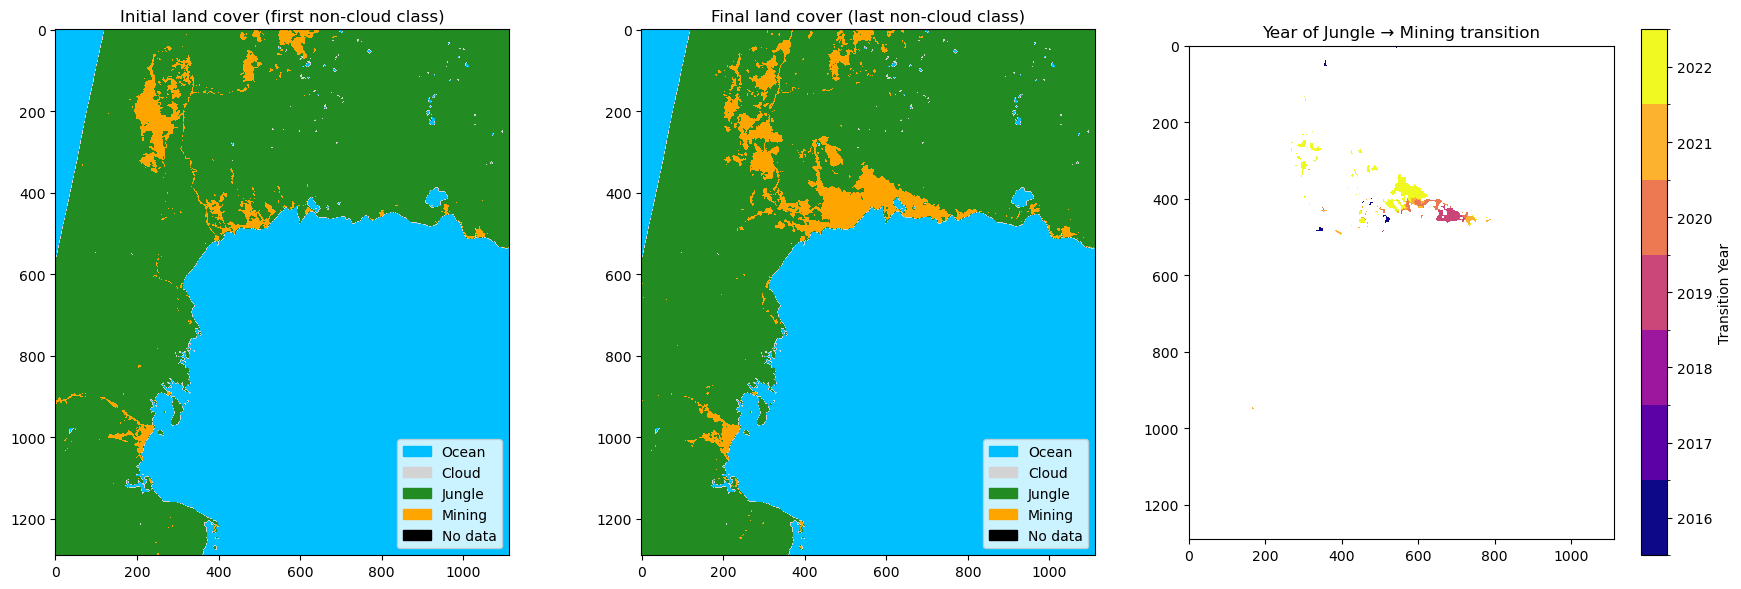

In [131]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

# -------------------------------
# 1. Load raster
# -------------------------------
path = "jungle_to_mine_change.tif"

with rasterio.open(path) as src:
    initial_state = src.read(1)
    final_state = src.read(2)
    change_year = src.read(3)

# -------------------------------
# 2. Class colors and labels
# -------------------------------
classes = {
    3: ("Ocean", "deepskyblue"),
    0: ("Cloud", "lightgrey"),
    1: ("Jungle", "forestgreen"),
    2: ("Mining", "orange"),
    -1: ("No data", "black")
}

vals = np.array(list(classes.keys()))
colors = [v[1] for v in classes.values()]
labels = [v[0] for v in classes.values()]

cmap_cat = ListedColormap(colors)
norm_cat = BoundaryNorm(np.arange(-1.5, 4.5, 1), cmap_cat.N)
legend_patches = [Patch(color=c, label=l) for c, l in zip(colors, labels)]

# -------------------------------
# 3. Change-year color setup
# -------------------------------
masked_years = np.where((change_year >= 2016) & (change_year <= 2023), change_year, np.nan)
years = np.arange(2016, 2024)
cmap_year = plt.cm.plasma
norm_year = BoundaryNorm(years - 0.5, cmap_year.N)

# -------------------------------
# 4. Plot
# -------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# --- Initial state
im1 = axes[0].imshow(initial_state, cmap=cmap_cat, norm=norm_cat)
axes[0].set_title("Initial land cover (first non-cloud class)")
axes[0].legend(handles=legend_patches, loc="lower right", frameon=True)

# --- Final state
im2 = axes[1].imshow(final_state, cmap=cmap_cat, norm=norm_cat)
axes[1].set_title("Final land cover (last non-cloud class)")
axes[1].legend(handles=legend_patches, loc="lower right", frameon=True)

# --- Jungle→Mining year
im3 = axes[2].imshow(masked_years, cmap=cmap_year, norm=norm_year)
axes[2].set_title("Year of Jungle → Mining transition")
cbar = plt.colorbar(im3, ax=axes[2], boundaries=years - 0.5, ticks=years)
cbar.set_label("Transition Year")

plt.tight_layout()
plt.show()
